# 07wk-2: 이미지분석 (1)

최규빈  
2022-10-18

> CNN– CNN 예비학습, CNN 구현 (CPU), CNN 구현 (GPU), BCEWithLogisticLoss

# 강의영상

> <https://youtube.com/playlist?list=PLQqh36zP38-ymnoeGZPPvaaB35JmhRiTi>

# import

In [1]:
import torch 
import torchvision
from fastai.vision.all import * 
import time

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

# data

`-` download data

In [12]:
path = untar_data(URLs.MNIST)

`-` training set

In [13]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set

In [14]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [15]:
X.shape,XX.shape,y.shape,yy.shape

# CNN 예비학습

## 기존의 MLP 모형

`-` 교재의 모형

In [4]:
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

`-` 왜 28 $\times$ 28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야
하는가?

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에
짜 맞추어서 이미지자료를 분석하는 느낌

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야
맞다.

## 새로운 아키텍처의 제시

`-` 예전

$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

-   $l_1$: 선형변환, feature를 뻥튀기하는 역할
-   $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화
-   $l_2$: 선형변환, 뻥튀기된 feature를 요약 하는 역할 (=데이터를
    요약하는 역할)

`-` 새로운 아키텍처

-   $conv$: feature를 뻥튀기하는 역할 (2d ver $l_1$ 느낌)
-   $relu$:
-   $pooling$: 데이터를 요약하는 역할

### CONV 레이어 (선형변환의 2D 버전)

`-` 우선 연산하는 방법만 살펴보자.

**(예시1)**

In [17]:
torch.manual_seed(43052)
_conv = torch.nn.Conv2d(1,1,(2,2)) # 입력1, 출력1, (2,2) window size
_conv.weight.data, _conv.bias.data

In [18]:
_X = torch.arange(0,4).reshape(1,2,2).float()
_X

In [19]:
(-0.1733)*0 + (-0.4235)*1 +\
(0.1802)*2 + (0.4668)*3 + 0.2037

In [20]:
_conv(_X)

**(예시2) 잘하면 평균도 계산하겠다?**

In [21]:
_conv.weight.data = torch.tensor([[[[1/4, 1/4],[1/4,1/4]]]])
_conv.bias.data = torch.tensor([0.0])

In [22]:
_conv(_X) , (0+1+2+3)/4

**(예시3) 이동평균?**

In [23]:
_X = torch.arange(0,25).float().reshape(1,5,5) 
_X

In [24]:
_conv(_X)

**(예시4) window size가 증가한다면? (2d의 이동평균느낌)**

In [25]:
_conv = torch.nn.Conv2d(1,1,(3,3)) # 입력1, 출력1, (3,3) window size
_conv.bias.data = torch.tensor([0.0])
_conv.weight.data = torch.tensor([[[[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]]])

In [26]:
_X,_conv(_X)

In [27]:
(1+2+3+6+7+8+11+12+13)/9

**(예시5) 피처뻥튀기**

In [28]:
_X = torch.tensor([1.0,1.0,1.0,1.0]).reshape(1,2,2)
_X

In [29]:
_conv = torch.nn.Conv2d(1,8,(2,2))
_conv.weight.data.shape,_conv.bias.data.shape

In [30]:
_conv(_X).reshape(-1)

In [31]:
torch.sum(_conv.weight.data[0,...])+_conv.bias.data[0],\
torch.sum(_conv.weight.data[1,...])+_conv.bias.data[1]

결국 아래를 계산한다는 의미

In [32]:
torch.sum(_conv.weight.data,axis=(2,3)).reshape(-1)+ _conv.bias.data

In [33]:
_conv(_X).reshape(-1)

***(잔소리) axis 사용 익숙하지 않으면 아래 꼭 들으세요..***

-   <https://guebin.github.io/IP2022/2022/04/11/(6주차)-4월11일.html> ,
    numpy공부 4단계: 축

## ReLU (2d)

In [34]:
_X = torch.randn(25).reshape(1,5,5)
_X

In [35]:
a1=torch.nn.ReLU()

In [36]:
a1(_X)

## Maxpooling 레이어

In [37]:
_maxpooling = torch.nn.MaxPool2d((2,2))

In [38]:
_X = torch.arange(16).float().reshape(1,4,4) 

In [39]:
_X, _maxpooling(_X) 

In [40]:
_X = torch.arange(25).float().reshape(1,5,5) 

In [41]:
_X, _maxpooling(_X) 

In [42]:
_X = torch.arange(36).float().reshape(1,6,6) 

In [43]:
_X, _maxpooling(_X) 

# CNN 구현 (CPU)

In [44]:
X.shape

## (1) Conv2d

In [45]:
c1 = torch.nn.Conv2d(1,16,(5,5))
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])

## (2) ReLU

In [46]:
a1 = torch.nn.ReLU()
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])

## (3) MaxPool2D

In [47]:
m1 =  torch.nn.MaxPool2d((2,2)) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])

## (4) 적당히 마무리하고 시그모이드 태우자

`-` 펼치자.

(방법1)

In [48]:
m1(a1(c1(X))).reshape(-1,2304).shape

In [49]:
16*12*12 

(방법2)

In [50]:
flttn = torch.nn.Flatten()

In [51]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])

`-` 2304 $\to$ 1 로 차원축소하는 선형레이어를 설계

In [52]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])

`-` 시그모이드

In [53]:
a2 = torch.nn.Sigmoid()

In [54]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)
print(a1(l1(flttn(m1(a1(c1(X)))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])
torch.Size([12665, 1])

`-` 네트워크 설계

In [55]:
net = torch.nn.Sequential(
    c1, # 2d: 컨볼루션(선형변환), 피처 뻥튀기 
    a1, # 2d: 렐루(비선형변환)
    m1, # 2d: 맥스풀링: 데이터요약
    flttn, # 2d->1d 
    l1, # 1d: 선형변환
    a2 # 1d: 시그모이드(비선형변환) 
)

In [56]:
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [57]:
t1= time.time()
for epoc in range(100): 
    ## 1
    yhat = net(X) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()
t2= time.time()
t2-t1

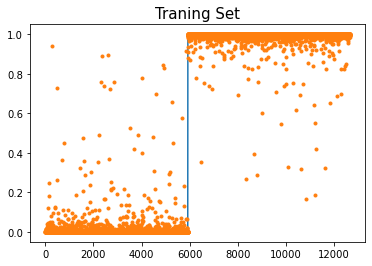

In [58]:
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title('Traning Set',size=15)

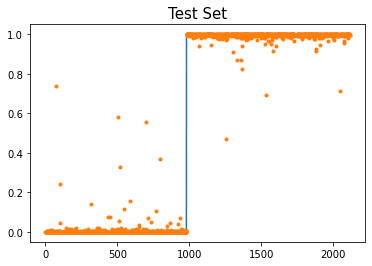

In [59]:
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title('Test Set',size=15)

# CNN 구현 (GPU)

## 1. dls

In [60]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [61]:
X.shape

In [62]:
len(X)/10

In [63]:
len(XX)

In [64]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [65]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

## 2. lrnr 생성: 아키텍처, 손실함수, 옵티마이저

In [66]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()

In [67]:
lrnr = Learner(dls,net,loss_fn)

## 3. 학습

In [68]:
lrnr.fit(10) 

## 4. 예측 및 시각화

In [69]:
net.to("cpu") 

`-` 결과를 시각화하면 아래와 같다.

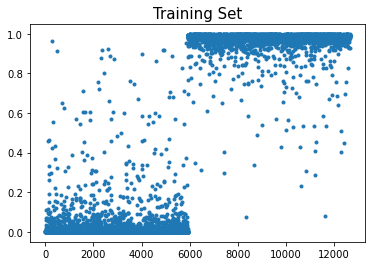

In [70]:
plt.plot(net(X).data,'.')
plt.title("Training Set",size=15)

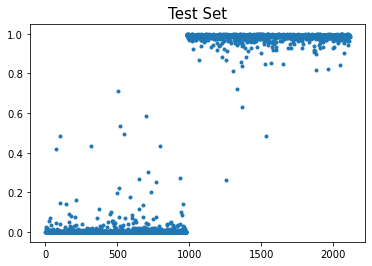

In [71]:
plt.plot(net(XX).data,'.')
plt.title("Test Set",size=15)

`-` 빠르고 적합결과도 좋음

## Lrnr 오브젝트

In [72]:
lrnr.model

In [73]:
net

In [74]:
id(lrnr.model), id(net)

In [75]:
lrnr.model(X)

## BCEWithLogitsLoss

`-` BCEWithLogitsLoss = Sigmoid + BCELoss - 왜 써요? 수치적으로 더 안정

`-` 사용방법

1.  dls 만들기

In [76]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [77]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [78]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

1.  lrnr생성

In [79]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCEWithLogitsLoss()
lrnr = Learner(dls,net,loss_fn) 

1.  학습

In [80]:
lrnr.fit(10)

1.  예측 및 시각화

In [81]:
net.to("cpu")

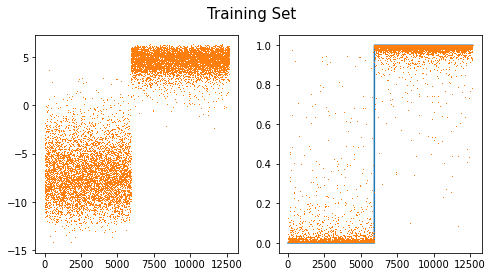

In [82]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).data,',',color="C1")
ax[1].plot(y)
ax[1].plot(a2(net(X)).data,',')
fig.suptitle("Training Set",size=15)

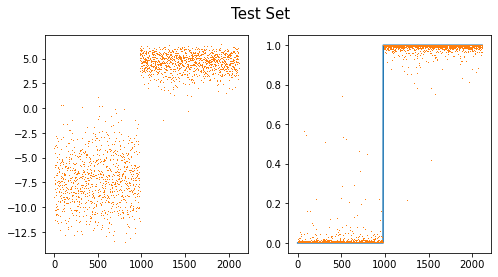

In [83]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(a2(net(XX)).data,',')
fig.suptitle("Test Set",size=15)